# Dependencies

In [1]:
import argparse

import os

import time
import torch

import matplotlib.pyplot as plt
import numpy as np

from collections import defaultdict
from model.dataloader import HELMETDataLoader
from model.dataloader import class_dict
from model.models import Darknet, load_weights, load_darknet_weights
from utils.utils import *

from IPython.display import clear_output

# Load in model

In [2]:
cfg_path = './cfg/yolov3_36.cfg'
weights_path = './weights/darknet53.conv.74'

In [3]:
### 

# Load in convolutional darknet.
# TODO: Set a default img_size for convenience.
def get_darknet(img_size, cfg=cfg_path):
    return Darknet(cfg, img_size)

img_size = 416

model = get_darknet(img_size=img_size)

# Load in weights
load_darknet_weights(model, weights_path)

# Dataloader

In [4]:
batch_size = 3

dataloader = HELMETDataLoader("./data/HELMET_DATASET_DUMMY", shuffle=True, batch_size=batch_size, resize=(img_size, img_size))

# Dataloader unit test

In [5]:
batch = next(iter(dataloader))

imgs, targets, annotations = batch

print('Image shape:', imgs[0].shape)

out = model(imgs[0].reshape(1, 3, img_size, img_size))

print('Output shape:', out.shape)
print('Targets shape:', targets[0].size())

Image shape: torch.Size([3, 416, 416])
Output shape: torch.Size([1, 10647, 41])
Targets shape: torch.Size([6, 5])


In [6]:
imgs[0].reshape(1, 3, img_size, img_size).shape

torch.Size([1, 3, 416, 416])

# Training loop

In [7]:
CUTOFF = 155
# Transfer learning (train only YOLO layers)
for i, (name, p) in enumerate(model.named_parameters()):
    # if p.shape[0] != 650:  # not YOLO layer
    #    p.requires_grad = False
    if i < CUTOFF:
        p.requires_grad = False

In [8]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))
# optimizer = torch.optim.SGD(
#     filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3,
#     momentum=.9, weight_decay=5e-4, nesterov=True
# )

Get device.

In [9]:
cuda_enable = True
cuda_available = torch.cuda.is_available()
if cuda_enable and cuda_available:
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print('Using device: ', device)

Using device:  cuda:0


Train loop.

In [10]:
N_EPOCHS = 50
PLOT_EVERY = 1

model.to(device)

num_classes = 36

plot_dict = {'loss': []}

error_count = 0
for epoch in range(1, N_EPOCHS + 1):
    since = time.time()

    # Train loop
    model.train()
    ui = -1
    rloss = defaultdict(float)  # running loss
    metrics = torch.zeros(4, num_classes)
    for imgs, targets, annotations in dataloader:
        if sum([len(x) for x in targets]) < 1:  # if no targets continue
            continue
        
        optimizer.zero_grad()  # Zero gradients
        loss = model(imgs.to(device), targets, requestPrecision=True)
        try:
            loss.backward()
        except:
            error_count += 1
        optimizer.step()

        # Compute running epoch-means of tracked metrics
        ui += 1
        metrics += model.losses['metrics']
        for key, val in model.losses.items():
            rloss[key] = (rloss[key] * ui + val) / (ui + 1)

        # Precision
        precision = metrics[0] / (metrics[0] + metrics[1] + 1e-16)
        k = (metrics[0] + metrics[1]) > 0
        if k.sum() > 0:
            mean_precision = precision[k].mean().item()
        else:
            mean_precision = 0

        # Recall
        recall = metrics[0] / (metrics[0] + metrics[2] + 1e-16)
        k = (metrics[0] + metrics[2]) > 0
        if k.sum() > 0:
            mean_recall = recall[k].mean().item()
        else:
            mean_recall = 0

    train_metric_dict = {
        'epoch': epoch,
        'loss': rloss['loss'],
        'x': rloss['x'],
        'y': rloss['y'],
        'w': rloss['w'],
        'h': rloss['h'],
        'conf': rloss['conf'],
        'cls': rloss['cls'],
        'mean_precision': mean_precision,
        'mean_recall': mean_recall,
        'nT': model.losses['nT'],
        'TP': model.losses['TP'].item(),
        'FP': model.losses['FP'].item(),
        'FN': model.losses['FN'].item()
    }
    print(train_metric_dict)
    
    time_elapsed = time.time() - since
    print('Train Time {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    if not (epoch - 1) % PLOT_EVERY:
        fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
        plot_dict['loss'].append(train_metric_dict['loss'])
        ax.plot(range(1, train_metric_dict['epoch'] + 1, PLOT_EVERY), plot_dict['loss'])
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        plt.show()
    clear_output(wait=True)

KeyboardInterrupt: 

# Detection test

In [11]:
opt = {
    'conf_thres': .5,
    'nms_thres': .45
}

In [16]:
imgs, targets, annotations = next(iter(dataloader))

model.to(device).eval()
img_detections = []

# Get detections
for img in imgs:
    with torch.no_grad():
        pred = model(img.to(device).reshape(1, 3, img_size, img_size)) # pred = model(chip)
        pred = pred[pred[:, :, 4] > opt['conf_thres']]

        if len(pred) > 0:
            detections = non_max_suppression(pred.unsqueeze(0), opt['conf_thres'], opt['nms_thres'])
            img_detections.extend(detections)
            

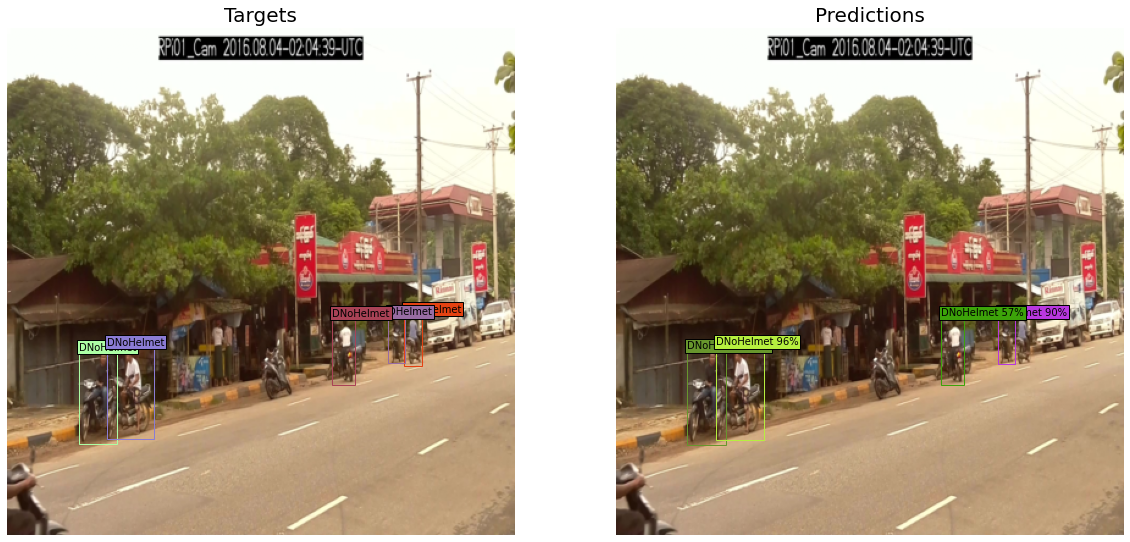

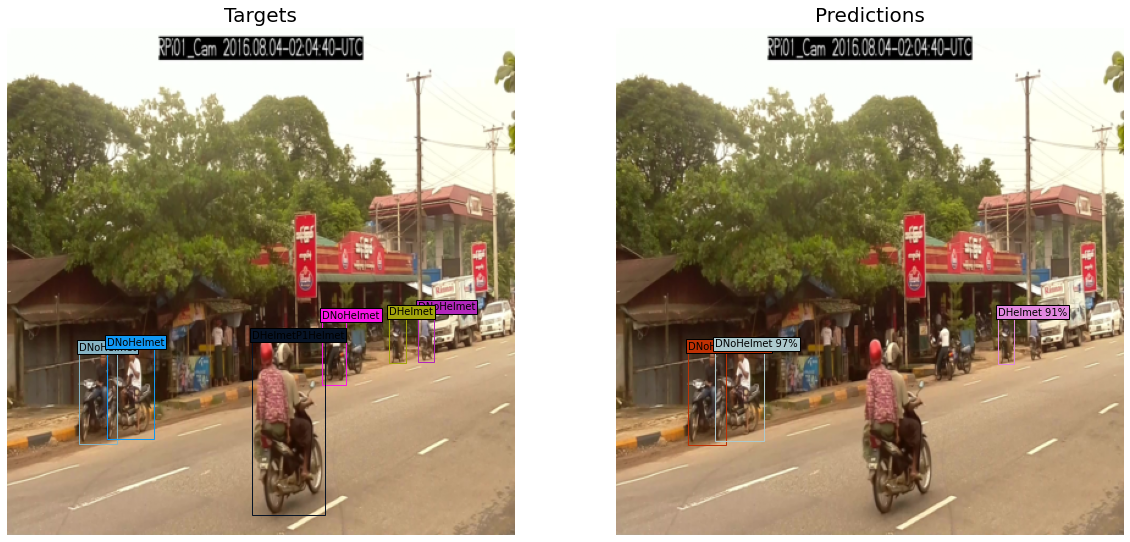

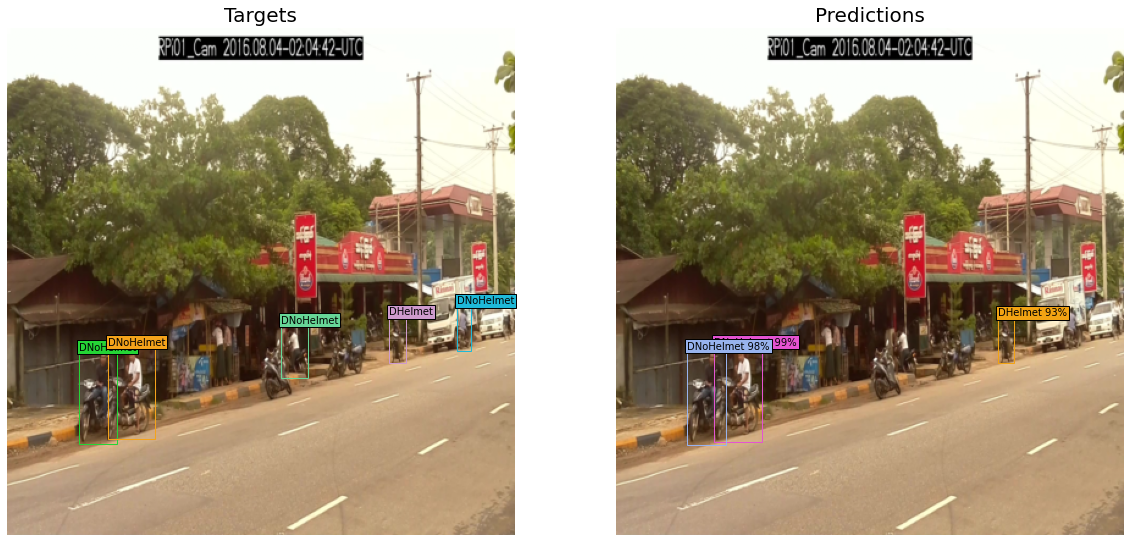

In [21]:
for img, target, detection in zip(imgs, targets, img_detections):
    # Figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    ax1.imshow(np.array(img).transpose([1, 2, 0]))
    ax2.imshow(np.array(img).transpose([1, 2, 0]))
    ax1.axis('off')
    ax2.axis('off')
    ax1.set_title('Targets', fontsize=20)
    ax2.set_title('Predictions', fontsize=20)

    for label, x1, y1, box_w, box_h in target:
        # Rescale coordinates to original dimensions
        box_h = (box_h * img.shape[1]).item()
        box_w = (box_w * img.shape[2]).item()
        y1 = (y1 * img.shape[1] - box_h / 2).round().item()
        x1 = (x1 * img.shape[2] - box_w / 2).round().item()

        x1, y1 = max(x1, 0), max(y1, 0)

        label = list(class_dict.keys())[int(label)]
        col = tuple(np.random.random(3))
        rect = plt.Rectangle((x1, y1), box_w, box_h, fc="none", ec=col)
        ax1.add_patch(rect)
        ax1.text(x1, y1, label, fontsize=10, bbox={'facecolor': col, 'pad': 2})
    
    # Draw bounding boxes and labels of detections
    if detection is not None:
        unique_classes = detection[:, -1].cpu().unique()

        for i in unique_classes:
            n = (detection[:, -1].cpu() == i).sum()
            # print('%g %ss' % (n, classes[int(i)]))

        for x1, y1, x2, y2, conf, cls_conf, cls_pred in detection:
            if len(class_dict.keys()) < int(cls_pred) - 1:
                continue
            
            # Rescale coordinates to original dimensions
            box_h = (y2 - y1) 
            box_w = (x2 - x1)

            label = list(class_dict.keys())[int(cls_pred)]
            col = tuple(np.random.random(3))
            rect = plt.Rectangle((x1, y1), box_w, box_h, fc="none", ec=col)
            ax2.add_patch(rect)
            ax2.text(x1, y1, label + ' ' + str( round(conf.item() * 100) ) + '%', 
                     fontsize=10, bbox={'facecolor': col, 'pad': 2})

    plt.show()